In [ ]:
#位相シフタとPDを想定した複素エンコーダ(alpha=0.6)
#新decoderで復元

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [ ]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data', 'MNIST_AE[5’]_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)

1206
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data\MNIST_AE[5’]_result


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [35]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [36]:
#Encoder5
class Encoder(nn.Module):
    def __init__(self,in_features,out_features,alpha=0.6):
        super(Encoder, self).__init__()
        real_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        imag_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        self.B = torch.complex(real_part, imag_part).detach()
        self.B.requires_grad = False

        self.alpha = alpha
    
    def forward(self, x):
        x = torch.exp(1j * self.alpha * x) #e^(iαx)
        x = x.T
        x = torch.matmul(self.B, x)
        x = torch.abs(x) ** 2
        x = x.T
        return x

In [37]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out):
        super(Decoder, self).__init__()
        self.decoder_fc1 = nn.Linear(num_in, int((num_in+num_out)/2))
        self.a1 = nn.Tanh()
        self.decoder_fc2 = nn.Linear(int((num_in+num_out)/2), num_out)
        self.a2 = nn.Sigmoid()

    def forward(self, x):
        x = self.decoder_fc1(x)
        x = self.a1(x)
        x = self.decoder_fc2(x)
        x = self.a2(x)
        return x

In [38]:
class AutoEncoder(nn.Module):
    def __init__(self,num_N):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(784, num_N)  
        self.decoder = Decoder(num_N, 784)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.encoder(x) 
        
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [39]:
DofIN = 784 ##
num_N = 98 ##

model = AutoEncoder(num_N)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
loss_train_ = []
loss_test_ = []

max_epochs = 10
for epoch in range(max_epochs):
    loss_train = 0
    loss_test = 0
    for (x,t) in train_dataloader:

        sys.stderr.write('\rEpoch: %d/%d' % (epoch, max_epochs)) 
        sys.stderr.flush()
        
        y = model(x)
        loss = criterion(y, x.view(x.size(0), -1)) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
       
    loss_train_avg = loss_train / len(train_dataloader)

    with torch.no_grad():
        for x, t in test_dataloader:
            y = model(x)
            loss = criterion(y, x.view(x.size(0), -1))
        
            loss_test += loss.item()

    loss_test_avg = loss_test / len(test_dataloader)

    loss_train_.append(loss_train_avg)
    loss_test_.append(loss_test_avg)
    



Epoch: 0/10

Epoch: 9/10

In [41]:
All_loss_train_avg = sum(loss_train_)/len(loss_train_)
All_loss_test_avg = sum(loss_test_)/len(loss_test_)

Last_loss_train = loss_train_[-1]
Last_loss_test = loss_test_[-1]

print('Train MSE AVG:  ',All_loss_train_avg)
print('Test MSE AVG:   ',All_loss_test_avg)

print('Train Last MSE: ',Last_loss_train)
print('Test Last MSE:  ',Last_loss_test)

Train MSE AVG:   0.01364505500959543
Test MSE AVG:    0.011193347291555257
Train Last MSE:  0.008487923891904453
Test Last MSE:   0.008205430922098458


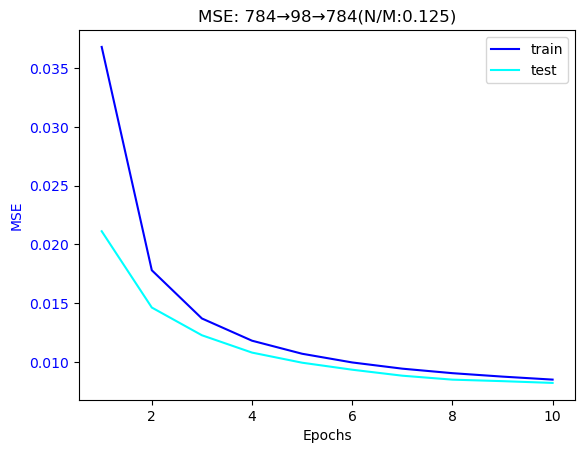

In [42]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
file_name = '%d_LOSS%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

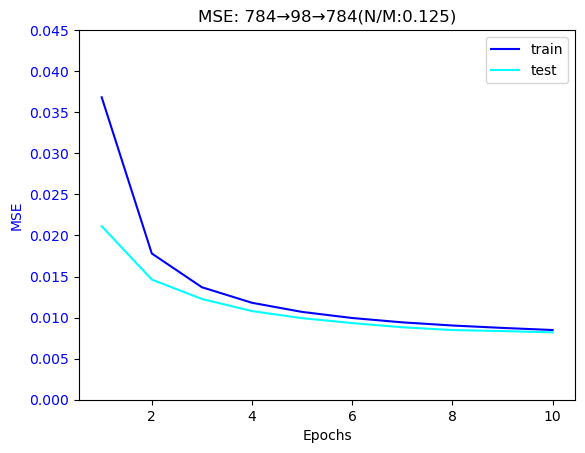

In [43]:
plt.plot(range(1,len(loss_train_)+1), loss_train_, label="train",color = 'blue')
plt.plot(range(1,len(loss_test_)+1), loss_test_, label="test",color = 'cyan')
plt.xlabel('Epochs')
plt.ylabel('MSE', color = 'blue')
plt.ylim(0,0.045)
plt.tick_params(axis='y', labelcolor='blue')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
file_name = '%d_LOSS%d→%d→%d_ex.png'%(int(formatted_date),DofIN,num_N,DofIN)
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

In [44]:
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] 
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

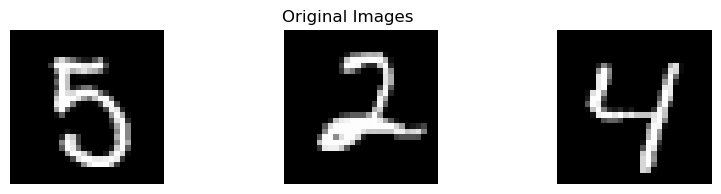

In [45]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:
        break
show_images(test_images, test_labels,"Original Images")

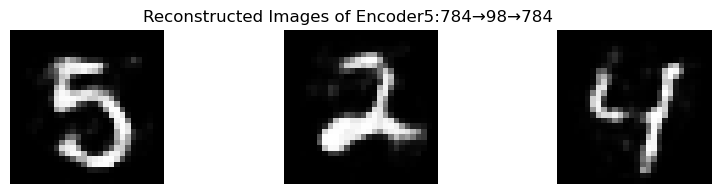

In [46]:
with torch.no_grad():
    reconstructed_images = model(test_images)
    show_images(reconstructed_images,test_labels, "Reconstructed Images of Encoder5:%d→%d→%d"%(DofIN,num_N,DofIN))
    file_name = '%d_ReImage%d→%d→%d.png'%(int(formatted_date),DofIN,num_N,DofIN)
    full_path = os.path.join(save_directory, file_name)
    plt.savefig(full_path, dpi=100, bbox_inches='tight')
    plt.show()

In [47]:
import csv
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data','texts') 
print(save_directory)
os.makedirs(save_directory, exist_ok=True)
file_name = 'AE[5_]_lis.csv'##
full_path = os.path.join(save_directory, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(loss_test_)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoEncoder_data\texts
